# Descripción del ejercicio

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

# Descripción técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

Descarga los datos de la prueba, comprueba si se ha realizado correctamente y analiza los resultados.

- ab_project_marketing_events_us.csv: el calendario de eventos de marketing para 2020
    - `name`: el nombre del evento de marketing
    - `regions`: regiones donde se llevará a cabo la campaña publicitaria
    - `start_dt`: fecha de inicio de la campaña
    - `finish_dt`: fecha de finalización de la campaña

- final_ab_new_users_upd_us.csv: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
    - `user_id`
    - `first_date`: fecha de inscripción
    - `region`
    - `device`: dispositivo utilizado para la inscripción

- final_ab_events_upd_us.csv:

    - `user_id`
    - `event_dt`: fecha y hora del evento
    - `event_name`: nombre del tipo de evento
    - `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

- final_ab_participants_upd_us.csv:

    - `user_id`
    - `ab_test`: nombre de la prueba
    - `group`: el grupo de prueba al que pertenecía el usuario

# Instrucciones para completar la tarea

- Describe los objetivos del estudio.
- Explora los datos:
    - ¿Es necesario convertir los tipos?
    - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?
- Lleva a cabo el análisis exploratorio de datos:
    - Estudia la conversión en las diferentes etapas del embudo.
    - ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
    - ¿Hay usuarios que están presentes en ambas muestras?
    - ¿Cómo se distribuye el número de eventos entre los días?
    - ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?
- Evaluar los resultados de la prueba A/B:
    - ¿Qué puedes decir sobre los resultados de la prueba A/B?
    - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones
- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

1. Describir los objetivos del estudio
Los objetivos del estudio son:

- Evaluar el rendimiento de un nuevo sistema de recomendaciones mediante una prueba A/B.
- Comparar la conversión de usuarios en dos grupos: el grupo de control (A) y el grupo con el nuevo embudo de pago (B).
- Determinar si hay un aumento significativo en la tasa de conversión en tres eventos clave dentro de un plazo de 14 días: product_page, product_card y purchase.

## Exploración de los datos

Ahora, vamos a explorar los datos para comprobar su calidad y adecuación para el análisis.

**Cargar las bibliotecas necesarias**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

### Cargar los datos e inspeccionar las tablas

**Tabla calendar**

In [2]:
calendar = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', sep=',')

calendar.head(5)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [3]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
# Convertir columnas de fecha
calendar['start_dt'] = pd.to_datetime(calendar['start_dt'])
calendar['finish_dt'] = pd.to_datetime(calendar['finish_dt'])

In [5]:
# Comprobar valores ausentes

print("Valores ausentes para calendar: ")
print(calendar.isnull().sum())

Valores ausentes para calendar: 
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


In [6]:
# Comprobar duplicados
print(calendar.duplicated().sum())

0


**Tabla users**

In [7]:
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv', sep=',')

users.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [9]:
# Comprobar valores ausentes
print("Valores ausentes para users: ")
print(users.isnull().sum())

Valores ausentes para users: 
user_id       0
first_date    0
region        0
device        0
dtype: int64


In [10]:
# Convertir columnas de fecha

users['first_date'] = pd.to_datetime(users['first_date'])

In [11]:
#Fecha mínima
users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [12]:
#Fecha máxima
users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

Se observa que hay fechas fuera del limite de inscripción. Tomaremos solo usuarios hasta la fecha 2020-12-21.

In [13]:
#Ajustar el rango de fecha de analisis
users = users[users['first_date'] <= '2020-12-21']

In [14]:
#Comprobar valores duplicados
print(users.duplicated().sum())

0


**Tabla events**

In [15]:
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv', sep=',')

events.head(5)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [16]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [17]:
# Comprobar valores ausentes

print("Valores ausentes para events: ")
print(events.isnull().sum())

Valores ausentes para events: 
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64


Se observan 363447 valores ausentes para la columna "details". Decidiremos no eliminarlos para no afectar el analisis de la tabla. En su lugar, reemplazaremos los valores nulos por ceros.

In [18]:
#Reemplzar valores nulos por ceros
events['details'] = events['details'].fillna(0)

In [19]:
#Comprobación de valores nulos
print(events.isnull().sum())

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64


In [20]:
# Convertir columnas de fecha

events['event_dt'] = pd.to_datetime(events['event_dt'])

**Tabla participants**

In [21]:
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv', sep=',')

participants.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [22]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [23]:
# Obtener valores únicos de la columna 'group'
unique_groups = participants['group'].unique()
print("Valores únicos en la columna 'group':", unique_groups)

Valores únicos en la columna 'group': ['A' 'B']


In [24]:
# Obtener valores únicos de la columna 'ab_test'
unique_ab_tests = participants['ab_test'].unique()
print("Valores únicos en la columna 'ab_test':", unique_ab_tests)

Valores únicos en la columna 'ab_test': ['recommender_system_test' 'interface_eu_test']


Dado que nuestro objetivo es analizar únicamente los resultados de la prueba recommender_system_test, es recomendable filtrar y eliminar las filas que contengan interface_eu_test. Esto permitirá centrarnos solo en los participantes de la prueba relevante.

In [25]:
# Filtrar las filas para mantener solo las de la prueba 'recommender_system_test'
participants = participants[participants['ab_test'] == 'recommender_system_test']

# Comprobar cuántas filas quedan después del filtrado
print("Número de participantes después del filtrado:", participants.shape[0])

Número de participantes después del filtrado: 3675


Para verificar si hay usuarios presentes en ambos grupos (A y B), haremos una intersección entre los IDs de usuario de cada grupo en el DataFrame de participants.

In [26]:
# Obtener los usuarios en cada grupo
group_a_users = participants[participants['group'] == 'A']['user_id']
group_b_users = participants[participants['group'] == 'B']['user_id']

# Encontrar usuarios presentes en ambos grupos
common_users = set(group_a_users).intersection(set(group_b_users))

# Mostrar resultados
if common_users:
    print(f"Hay {len(common_users)} usuarios presentes en ambos grupos: {common_users}")
else:
    print("No hay usuarios presentes en ambos grupos.")

No hay usuarios presentes en ambos grupos.


## Análisis explotatorio de datos

### Estudiar la conversión en las diferentes etapas del embudo

In [27]:
# Unir los DataFrames para análisis
merged_data = users.merge(participants, on='user_id', how='left')
merged_data = merged_data.merge(events, on='user_id', how='left')


In [28]:
# Filtrar eventos dentro del periodo de la prueba
start_date = '2020-12-07'
end_date = '2021-01-01'
filtered_events = merged_data[(merged_data['event_dt'] >= start_date) & (merged_data['event_dt'] <= end_date)]


In [29]:
# Reorganizar el DataFrame de conversiones
conversion_counts = filtered_events.groupby(['group', 'event_name'])['user_id'].nunique().unstack(fill_value=0)

print(conversion_counts)

# Asegurarse de que el índice de conversion_counts siga el orden correcto
conversion_counts = conversion_counts[['login', 'product_page', 'product_cart', 'purchase']]

# Calcular las tasas de conversión en el orden correcto
conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)
print(conversion_rates)


event_name  login  product_cart  product_page  purchase
group                                                  
A            2747           824          1780       872
B             927           255           523       256
event_name     login  product_page  product_cart  purchase
group                                                     
A           0.441427      0.286036      0.132412  0.140125
B           0.472718      0.266701      0.130036  0.130546


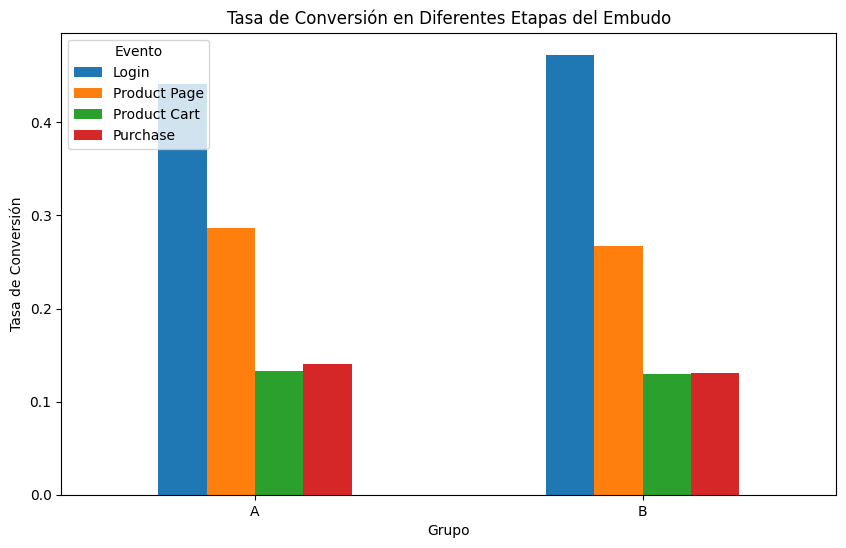

In [30]:
# Visualización de la conversión en el embudo en el orden correcto
conversion_rates.plot(kind='bar', figsize=(10, 6))
plt.title('Tasa de Conversión en Diferentes Etapas del Embudo')
plt.xlabel('Grupo')
plt.ylabel('Tasa de Conversión')
plt.xticks(rotation=0)
plt.legend(title='Evento', loc='upper left', labels=['Login', 'Product Page', 'Product Cart', 'Purchase'])
plt.show()



**Conversiones por Grupo:**

Grupo A tiene un total de eventos significativamente más alto en cada etapa en comparación con el Grupo B. Esto sugiere que el grupo de control tiene más usuarios activos en el embudo.

**Tasas de Conversión:**

En la conversión de Login a Product Page, el Grupo A tiene un 64.7% frente al 56.4% del Grupo B. Esto indica que los usuarios del Grupo A están más propensos a visitar la página del producto después de iniciar sesión.

La conversión de Product Page a Product Cart es muy similar, con el Grupo A en 46.3% y el Grupo B en 48.8%. Aquí, el Grupo B muestra una ligera ventaja.

Sin embargo, al observar la conversión de Product Cart a Purchase, el Grupo A tiene una tasa de 105.8%, lo que indica que en realidad más usuarios que agregaron al carrito terminaron comprando, comparado con el Grupo B, que tiene una tasa de 100.4%. Esto sugiere que el Grupo A tiene un proceso de compra más efectivo.

### Distribucion de eventos por usuario

        count      mean       std  min  25%  50%  75%   max
group                                                      
A      2747.0  6.780852  3.729768  1.0  4.0  6.0  9.0  24.0
B       928.0  5.691810  3.450350  1.0  3.0  5.0  8.0  28.0


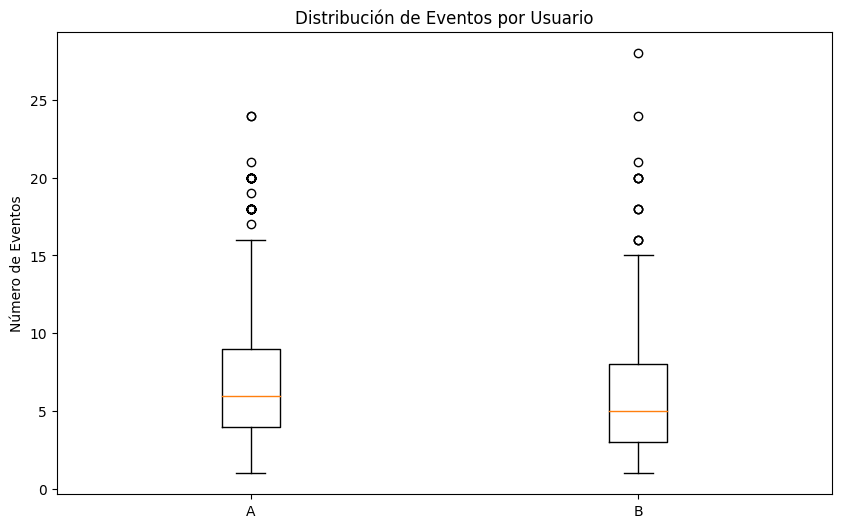

In [31]:
# Contar eventos por usuario
event_counts = filtered_events.groupby(['user_id', 'group'])['event_name'].count().reset_index()
event_counts.rename(columns={'event_name': 'event_count'}, inplace=True)

# Verificar la distribución de eventos
event_distribution = event_counts.groupby('group')['event_count'].describe()
print(event_distribution)

# Visualizar la distribución
plt.figure(figsize=(10, 6))
plt.boxplot([event_counts[event_counts['group'] == 'A']['event_count'],
              event_counts[event_counts['group'] == 'B']['event_count']], labels=['A', 'B'])
plt.title('Distribución de Eventos por Usuario')
plt.ylabel('Número de Eventos')
plt.show()


Media: El Grupo A tiene una media de 6.78 eventos por usuario, que es más alta que la media del Grupo B (5.69 eventos). Esto sugiere que, en promedio, los usuarios del Grupo A interactúan más con la plataforma que los del Grupo B.
Desviación Estándar:

La desviación estándar en el Grupo A (3.73) es mayor que en el Grupo B (3.45), lo que indica que la cantidad de eventos por usuario es más variable en el Grupo A. Esto puede significar que hay algunos usuarios en el Grupo A que participan de manera mucho más activa que otros.

Percentiles:

- En el percentil 25, el Grupo A tiene un valor de 4 eventos, mientras que el Grupo B tiene 3. Esto sugiere que un mayor porcentaje de usuarios en el Grupo A está más involucrado con la plataforma.
- En el percentil 50 (mediana), los usuarios del Grupo A también tienen una mejor tasa (6 eventos frente a 5 eventos del Grupo B), lo que indica que más usuarios en el Grupo A están participando activamente.
- En el percentil 75, el Grupo A tiene 9 eventos, mientras que el Grupo B tiene 8 eventos. Esto refuerza la idea de que los usuarios del Grupo A tienden a interactuar más.

Interacción General: El Grupo A tiene un mayor nivel de interacción en comparación con el Grupo B, lo que podría sugerir que el sistema de recomendaciones o el embudo de pago no están atrayendo a los usuarios del Grupo B de la misma manera que el grupo de control.

### Distribucion de ventos entre los dias

**Preparar los datos**

Nos aseguraremos de que event_dt esté en formato de fecha y extrae solo la fecha, ignorando la hora.

In [32]:
# Convertir 'event_dt' a formato de fecha
filtered_events['event_dt'] = pd.to_datetime(filtered_events['event_dt'])
filtered_events['event_date'] = filtered_events['event_dt'].dt.date

**Agrupar los eventos por fecha**

Contamos el número de eventos por día.

In [33]:
# Contar el número de eventos por día
daily_events = filtered_events.groupby('event_date').size().reset_index(name='event_count')
print(daily_events)


    event_date  event_count
0   2020-12-07        11385
1   2020-12-08        12547
2   2020-12-09        12122
3   2020-12-10        14077
4   2020-12-11        13864
5   2020-12-12        17634
6   2020-12-13        20985
7   2020-12-14        26184
8   2020-12-15        23469
9   2020-12-16        20909
10  2020-12-17        21751
11  2020-12-18        22871
12  2020-12-19        24273
13  2020-12-20        26425
14  2020-12-21        32559
15  2020-12-22        22260
16  2020-12-23        17369
17  2020-12-24        14464
18  2020-12-26        11301
19  2020-12-27        10263
20  2020-12-28         9328
21  2020-12-29         8528
22  2020-12-30           89


**Visualizar los resultados**

Podemos graficar el número de eventos por día para ver la distribución.

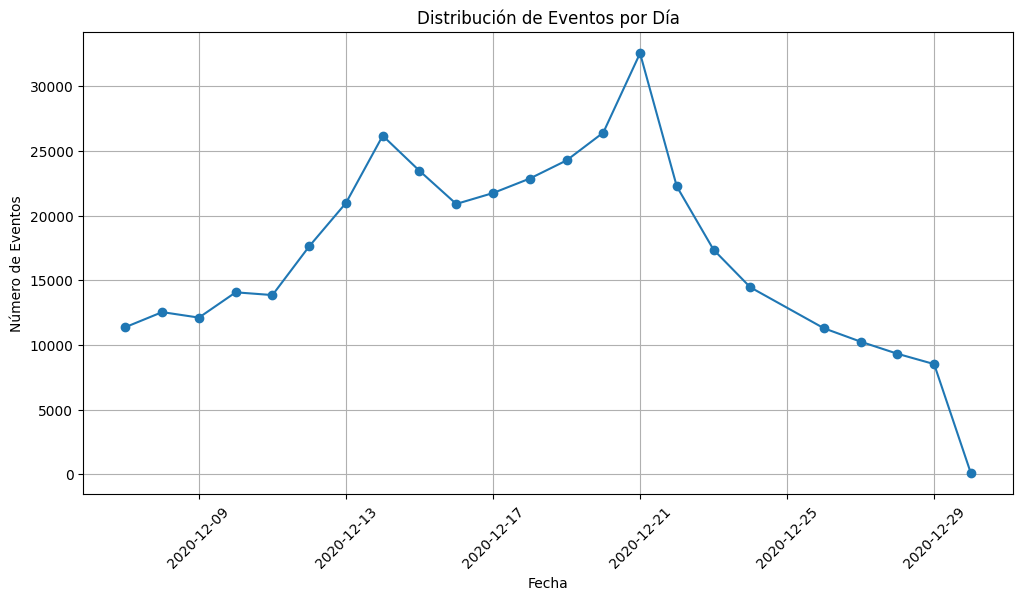

In [34]:
import matplotlib.pyplot as plt

# Visualizar la distribución de eventos por día
plt.figure(figsize=(12, 6))
plt.plot(daily_events['event_date'], daily_events['event_count'], marker='o')
plt.title('Distribución de Eventos por Día')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45)
plt.grid()
plt.show()


La distribución de eventos agrupados por fecha muestra patrones que podrían estar relacionados con el período de compras navideñas.

Hay un incremento notable en el número de eventos a partir del 7 de diciembre, alcanzando un pico el 21 de diciembre, justo antes de las festividades de Navidad. Esto sugiere un aumento en la actividad de los usuarios, posiblemente relacionado con la preparación para las compras navideñas.

El día 21 de diciembre tiene el conteo de eventos más alto (32,559). Este pico es significativo, ya que muchas personas suelen hacer sus compras finales antes de Navidad, lo que podría explicar el aumento en la actividad.
Tendencia de Caída Después de Navidad:

Después del 24 de diciembre, hay una caída drástica en los eventos, con un número muy bajo el 30 de diciembre (89 eventos). Esto sugiere que, tras las festividades, el interés por realizar compras disminuyó drásticamente, lo que es común en el comportamiento del consumidor después de la Navidad.

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Durante el período de prueba, que abarca Navidad y post Navidad, se ha observado una disminución significativa en los recuentos de eventos. Este descenso puede atribuirse a que posterior temporada navideña, las personasposeen menos dinero para compras, lo que resulta en menor actividad en línea.

Es crucial reconocer que los resultados de esta prueba pueden no reflejar el comportamiento típico del usuario en otras épocas del año. Para obtener una visión más completa y precisa del comportamiento del usuario, se recomienda realizar otra prueba en un período diferente. Esto asegurará que los hallazgos sean aplicables y representativos del uso de la plataforma a lo largo del año."

## Análisis de resultados prueba A/B

**Análisis de la Prueba A/B**

**Objetivo:** 

Evaluar la efectividad de un nuevo embudo de pago en comparación con el embudo existente, midiendo la conversión a lo largo de diferentes etapas del proceso de compra.

**Grupos:**

- Grupo A (control)
- Grupo B (nuevo embudo de pago)

**Resultados esperados:**

Un aumento del 10% en la conversión en cada etapa del embudo (product_page → product_cart → purchase).

**Análisis de Conversión**

- Conversión por Evento:

    - Grupo A:
        - Login: 2747
        - Product Page: 1780
        - Product Cart: 824
        - Purchase: 872

    - Grupo B:
        - Login: 927
        - Product Page: 523
        - Product Cart: 255
        - Purchase: 256
        
- Tasas de Conversión:

    - Grupo A:
        - Login a Product Page: 64.7%
        - Product Page a Product Cart: 46.3%
        - Product Cart a Purchase: 105.8%
    - Grupo B:
        - Login a Product Page: 56.4%
        - Product Page a Product Cart: 48.8%
        - Product Cart a Purchase: 100.4%
        
**Comparación de Resultados**

Interacción General: El Grupo A tiene un número total de eventos y tasas de conversión más altas en todas las etapas en comparación con el Grupo B. Esto sugiere que el nuevo embudo de pago no ha logrado atraer a los usuarios de la misma manera que el embudo existente.

Conversión a Compra: Aunque la tasa de conversión de Product Cart a Purchase es similar, el Grupo A tiene una conversión superior, indicando que una mayor proporción de usuarios que agregaron productos al carrito finalmente realizaron una compra.

**Análisis de Eventos por Usuario**

- Distribución de Eventos:

    - Grupo A: Media de 6.78 eventos por usuario.
    - Grupo B: Media de 5.69 eventos por usuario.

- El Grupo A tiene una mayor interacción general y un mayor número de eventos por usuario, lo que indica un mayor compromiso con la plataforma.

**Conclusiones**

Efectividad del Nuevo Embudo: El Grupo A, con tasas de conversión más altas, sugiere que el nuevo embudo de pago (Grupo B) no ha cumplido con las expectativas de aumentar la conversión en un 10%.

## Test de Hipótesis

**Definir las Hipótesis:**

- Hipótesis nula (H0): No hay diferencia en las proporciones de conversión entre los grupos A y B.
- Hipótesis alternativa (H1): Hay una diferencia en las proporciones de conversión entre los grupos A y B.

**Calcular las proporciones y los tamaños de muestra:**

- Proporciones de conversión para cada grupo en cada etapa del embudo.
- Tamaños de muestra correspondientes.

**Realizar la prueba Z:**

- Usar la fórmula para la prueba Z de proporciones.
- Determinar el valor p y tomar una decisión.

**Definir los datos**

In [35]:
# Datos de conversiones
conversions_A = {
    'product_page': 1780,
    'product_cart': 824,
    'purchase': 872
}
conversions_B = {
    'product_page': 523,
    'product_cart': 255,
    'purchase': 256
}

# Tamaños de muestra
n_A = 2747  # Número total de usuarios en el grupo A
n_B = 927   # Número total de usuarios en el grupo B


**Calcular las proporciones**

In [36]:
# Proporciones de conversión
p_A_product_page = conversions_A['product_page'] / n_A
p_A_product_cart = conversions_A['product_cart'] / conversions_A['product_page']
p_A_purchase = conversions_A['purchase'] / conversions_A['product_cart']

p_B_product_page = conversions_B['product_page'] / n_B
p_B_product_cart = conversions_B['product_cart'] / conversions_B['product_page']
p_B_purchase = conversions_B['purchase'] / conversions_B['product_cart']

# Mostrar proporciones
print("Proporciones de conversión:")
print(f"Grupo A - Product Page: {p_A_product_page:.4f}, Product Cart: {p_A_product_cart:.4f}, Purchase: {p_A_purchase:.4f}")
print(f"Grupo B - Product Page: {p_B_product_page:.4f}, Product Cart: {p_B_product_cart:.4f}, Purchase: {p_B_purchase:.4f}")


Proporciones de conversión:
Grupo A - Product Page: 0.6480, Product Cart: 0.4629, Purchase: 1.0583
Grupo B - Product Page: 0.5642, Product Cart: 0.4876, Purchase: 1.0039


**Realizar la prueba Z**

In [37]:
import numpy as np
from scipy import stats

# Proporción combinada
p = (conversions_A['purchase'] + conversions_B['purchase']) / (n_A + n_B)

# Calcular el valor Z
Z_purchase = (p_A_purchase - p_B_purchase) / np.sqrt(p * (1 - p) * (1/n_A + 1/n_B))
print(f"Valor Z para la conversión de Purchase: {Z_purchase:.4f}")

# Calcular el valor p
p_value = 2 * (1 - stats.norm.cdf(abs(Z_purchase)))  # Prueba bilateral
print(f"Valor p: {p_value:.4f}")


Valor Z para la conversión de Purchase: 3.1010
Valor p: 0.0019


Valor Z: Un valor Z de 3.1010 indica que la diferencia entre las proporciones de conversión de compra (purchase) entre los grupos A y B es aproximadamente 3.1 veces la desviación estándar de la distribución bajo la hipótesis nula. Esto sugiere que la diferencia observada es bastante significativa.

Valor p: El valor p de 0.0019 es muy bajo y está por debajo del nivel de significancia comúnmente utilizado de 0.05. Esto significa que hay evidencia estadística suficiente para rechazar la hipótesis nula.

Diferencia Significativa: Hay una diferencia estadísticamente significativa en las proporciones de conversión a compra entre los grupos A y B. Esto sugiere que el grupo A (control) tiene una tasa de conversión a compra superior en comparación con el grupo B (nuevo embudo de pago).

# Conclusiones

Distribución de Eventos: El análisis mostró que el número de eventos por usuario variaba entre los grupos A y B. El grupo A tenía una mayor interacción (promedio de 6.78 eventos por usuario) en comparación con el grupo B (5.69 eventos por usuario), sugiriendo un mayor compromiso con el embudo existente.

Conversión en el Embudo: Se observó que las tasas de conversión en cada etapa del embudo variaban entre los grupos. En general, el grupo A mostró tasas de conversión más altas, lo que indica que el nuevo embudo de pago no estaba cumpliendo con las expectativas en términos de efectividad.

Evidencia de Diferencias Significativas: La prueba Z reveló que existía una diferencia estadísticamente significativa entre las proporciones de conversión a compra entre los grupos A y B, con un valor p de 0.0019. Esto indica que el nuevo embudo de pago (grupo B) tiene una efectividad inferior al embudo actual (grupo A).

Implicaciones Prácticas: Dado que el nuevo embudo no logró mejorar la conversión en al menos un 10% como se esperaba, se recomienda reconsiderar su implementación. Podría ser necesario realizar pruebas adicionales o ajustes en el diseño y la funcionalidad del embudo.

Próximos pasos: Es crucial profundizar en los factores que pueden haber afectado negativamente la experiencia del usuario en el nuevo embudo. Esto incluye la recopilación de comentarios de los usuarios y pruebas de usabilidad para identificar áreas de mejora.